# ADALINE の 確率的勾配降下法(SGD) で学習

In [1]:
from numpy.random import seed
class AdalineSGD(object):
    """ADALINE with SGD optimizer
    パラメータ
    --------------
    eta : float
        学習率
    n_iter : int
        トレーニングデータのトレーニング回数
    shuffle : bool (default: True)
        循環を回避するために各エポックでトレーニングデータをシャッフルする
    random_state : int (default: None)
        シャッフルに使用するrandom_stateを設定し、重みを初期化
    """
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        if random_state:
            seed(random_state)

    def fit(self, X, y):
        """トレーニングデータに適合させる"""
        self._initialize_weights(X.shape[1]) # 重みベクトルの生成
        self.cost_ = [] # コストを格納するリスの生成
        # トレーニング回数分トレーニングデータを反復
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for xi, target in zip(X, y):
                cost.append(self._update_weights(xi, target))
            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)
        return self
        
    def partial_fit(self, X, y):
        """重みを再初期化することなくトレーニングデータに適合させる"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
            if y.ravel().shape[0] > 1:
                for xi, target in zip(X, y):
                    self._update_weights(xi, target)
            else:
                self._update_weights(X, y)
            return self

    def _shuffle(self, X, y):
        """トレーニングデータをシャッフル"""
        r = np.random.permutation(len(y))
        return X[r], y[r]

    def _initialize_weights(self, m):
        """重みを0に初期化"""
        self.w_ = np.zeros(1 + m) # バイアスノード追加
        self.w_initialized = True

    def _update_weights(self, xi, target):
        """重みを更新"""
        output = self.activation(xi) # 活性化関数の計算
        error = (target - output) # 誤差の計算
        self.w_[1:] += self.eta * xi.dot(error) # wjの更新 (j = 1, ..., m)
        self.w_[0] += self.eta * error # w0の更新
        cost = 0.5 * error**2 # コストの計算
        return cost
        
    def net_input(self, X):
        """総入力を計算"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """線形活性化関数の出力を計算"""
        return self.net_input(X)

    def predict(self, X):
        """予測結果を返す"""
        return np.where(self.activation(X) >= 0.0, 1, -1)


In [2]:
# データの読み込みと整形
import pandas as pd
import numpy as np

# UCI Machine Learning Repository から Irisデータ・セットを読み込む
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data',
                               header=None)

y = df.iloc[0:100, 4].values # 1-100行目の目的変数(index 4)を取得
y = np.where(y == 'Iris-setosa', -1, 1) # Iris-setosa を -1, Iris-virginica を 1 に変換
X = df.iloc[0:100, [0, 2]].values # 1-100行目の1, 3列目(index 0, 2)を取得


# 各列の標準化
X_std = np.copy(X) # コピー
X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()

In [3]:
# 2次元のデータセットの決定境界 (decision boundary) を可視化するメソッドの定義
from matplotlib.colors import ListedColormap
def plot_decision_regions(X, y, classifier, resolution=0.02):
    # マーカーとカラーマップの準備
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # 決定領域のプロット
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    # グリッドポイントの作成
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                                              np.arange(x2_min, x2_max, resolution))
    
    # 各特徴量を1次元配列に変換して予測を実行
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    
    # 予測結果を元のグリッドポイントのデータサイズに変換
    Z = Z.reshape(xx1.shape)
    
    # グリッドポイントの等高線のプロット
    plt.contourf(xx1, xx2, Z, alpha=0.4)
    
    # 軸の範囲の設定
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    # クラスごとにサンプルをプロット
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha=0.8,
                            c=cmap(idx), marker=markers[idx], label=cl)

In [4]:
# SGDによるADALINEの学習
ada = AdalineSGD(n_iter=15, eta=0.01, random_state=1)
ada.fit(X_std, y)

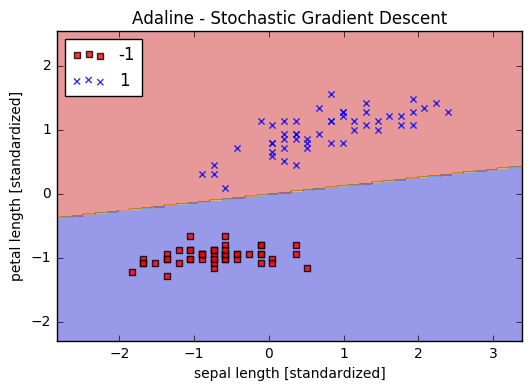

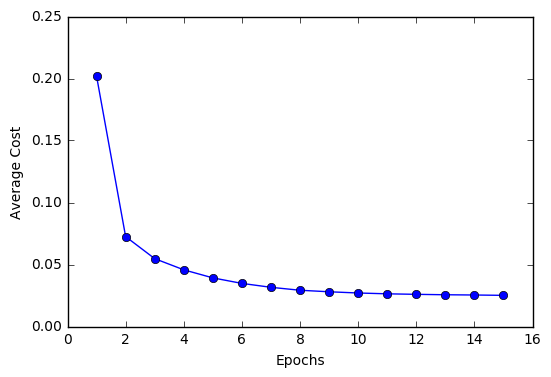

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

# 境界領域のプロット
plot_decision_regions(X_std, y, classifier=ada)
plt.title('Adaline - Stochastic Gradient Descent')
plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc='upper left')
plt.show()

# 学習曲線のプロット
# 平均コストがすぐに減少していることがわかる
plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Average Cost')
plt.show()